In [ ]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_colwidth", 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x) 

In [57]:
df = pd.read_parquet("transaction_fraud_data.parquet")
print(df.shape)
df.head(1)


(7483766, 23)


,transaction_id,customer_id,card_number,timestamp,vendor_category,vendor_type,vendor,amount,currency,country,city,city_size,card_type,is_card_present,device,channel,device_fingerprint,ip_address,is_outside_home_country,is_high_risk_vendor,is_weekend,last_hour_activity,is_fraud
0,TX_a0ad2a2a,CUST_72886,6646734767813109,2024-09-30 00:00:01.034820,Restaurant,fast_food,Taco Bell,294.87,GBP,UK,Unknown City,medium,Platinum Credit,False,iOS App,mobile,e8e6160445c935fd0001501e4cbac8bc,197.153.60.199,False,False,False,"{'num_transactions': 1197, 'total_amount': 33498556.080464985, 'unique_merchants': 105, 'unique_...",False


# EDA

In [5]:
df.columns

Index(['transaction_id', 'customer_id', 'card_number', 'timestamp',
       'vendor_category', 'vendor_type', 'vendor', 'amount', 'currency',
       'country', 'city', 'city_size', 'card_type', 'is_card_present',
       'device', 'channel', 'device_fingerprint', 'ip_address',
       'is_outside_home_country', 'is_high_risk_vendor', 'is_weekend',
       'last_hour_activity', 'is_fraud'],
      dtype='object')

In [6]:
df.head(1)

,transaction_id,customer_id,card_number,timestamp,vendor_category,vendor_type,vendor,amount,currency,country,city,city_size,card_type,is_card_present,device,channel,device_fingerprint,ip_address,is_outside_home_country,is_high_risk_vendor,is_weekend,last_hour_activity,is_fraud
0,TX_a0ad2a2a,CUST_72886,6646734767813109,2024-09-30 00:00:01.034820,Restaurant,fast_food,Taco Bell,294.87,GBP,UK,Unknown City,medium,Platinum Credit,False,iOS App,mobile,e8e6160445c935fd0001501e4cbac8bc,197.153.60.199,False,False,False,"{'num_transactions': 1197, 'total_amount': 33498556.080464985, 'unique_merchants': 105, 'unique_...",False


In [7]:
cur_exc = pd.read_parquet("historical_currency_exchange.parquet")
cur_exc = cur_exc.melt(id_vars="date", var_name="currency")

df["date"] = df.timestamp.dt.date
df = df.merge(
    cur_exc,
    how="left",
    on=["date", "currency"],
)
df["in_usd"] = df.amount / df.value
df.sample(2)

,transaction_id,customer_id,card_number,timestamp,vendor_category,vendor_type,vendor,amount,currency,country,city,city_size,card_type,is_card_present,device,channel,device_fingerprint,ip_address,is_outside_home_country,is_high_risk_vendor,is_weekend,last_hour_activity,is_fraud,date,value,in_usd
1048397,TX_f8a8fe97,CUST_25565,375568548479792,2024-10-04 09:25:46.169014,Grocery,physical,Publix,378.83,USD,USA,San Diego,medium,Premium Debit,False,Chrome,web,60cca50625ae275d296f7c57d22067b3,60.228.252.210,False,False,False,"{'num_transactions': 666, 'total_amount': 19738766.158431955, 'unique_merchants': 105, 'unique_c...",False,2024-10-04,1.000000,378.830000
4273439,TX_e23b8345,CUST_95847,6106202375904044,2024-10-17 17:18:39.450996,Grocery,physical,Trader Joe's,125.77,CAD,Canada,Unknown City,medium,Basic Credit,False,Safari,web,01f278501855b8755fcd5ba8de701519,211.114.42.225,False,False,False,"{'num_transactions': 221, 'total_amount': 5503001.208405631, 'unique_merchants': 92, 'unique_cou...",False,2024-10-17,1.375184,91.456824


## Гипотеза 1: некоторые комбинации device x channel
Некоторые устройства и каналы легче джейлбрейкнуть, подменить ip и так далее

Вывод: сначала казалось, что подтвердилась – для некоторых комбо fraud rate был 1. Но теперь кажется, что может быть какая-то ошибка в данных, потому что все операции с  POS отнесены к мошенническим. Я бы задала этот вопрос коллегам, предоставившим данные.

In [8]:
df.channel.value_counts()

channel
web       4563141
mobile    2269578
pos        651047
Name: count, dtype: int64

In [9]:
df[df.channel=="pos"].is_fraud.value_counts()

is_fraud
True    651047
Name: count, dtype: int64

  channel           device  total_transactions  fraud_transactions  fraud_rate
0     pos      Chip Reader              217324              217324    1.000000
1     pos  Magnetic Stripe              217204              217204    1.000000
2     pos      NFC Payment              216519              216519    1.000000
3     web          Firefox             1120952              142171    0.126831
4     web           Safari             1120245              141379    0.126204
5  mobile      Android App             1126117              140844    0.125070
6  mobile          iOS App             1143461              140306    0.122703
7     web           Chrome             1132384              140087    0.123710
8     web             Edge             1189560              138885    0.116753


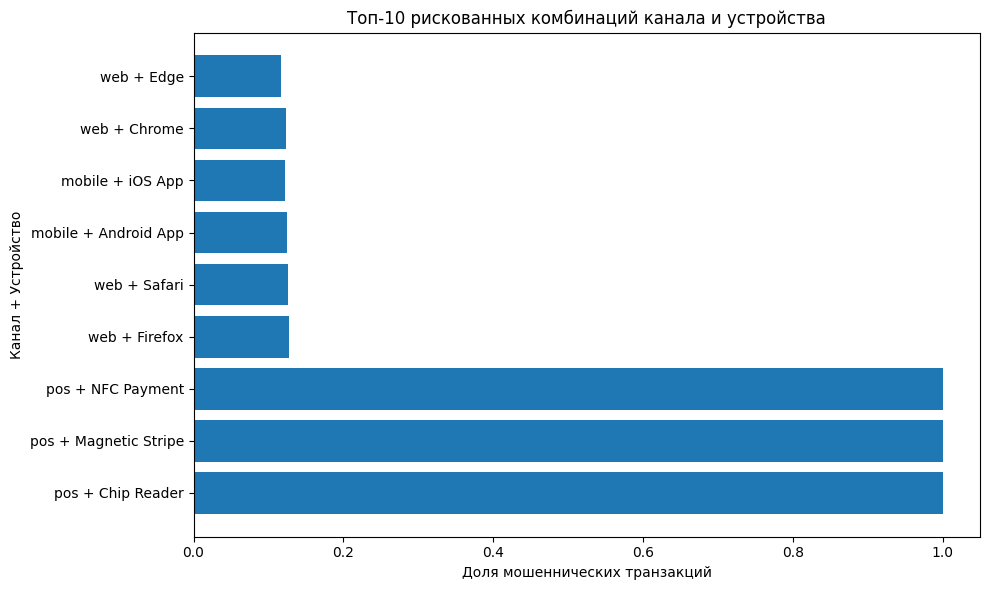

In [10]:
channel_device_df = (
    df.groupby(["channel", "device"])
    .agg(
        total_transactions=("is_fraud", "size"),
        fraud_transactions=("is_fraud", "sum"),
        fraud_rate=("is_fraud", "mean")
    )
    .sort_values("fraud_transactions", ascending=False)
    .reset_index()
)


print(channel_device_df.head(10))


top_10 = channel_device_df.head(10)
plt.figure(figsize=(10, 6))
plt.barh(
    width=top_10["fraud_rate"],
    y=top_10["channel"] + " + " + top_10["device"]
)
plt.title("Топ-10 рискованных комбинаций канала и устройства")
plt.xlabel("Доля мошеннических транзакций")
plt.ylabel("Канал + Устройство")
plt.tight_layout()
plt.show()

Посмотрим без pos. Тут гипотеза не подтверждается.

  channel       device  total_transactions  fraud_transactions  fraud_rate
0     web      Firefox             1120952              142171    0.126831
1     web       Safari             1120245              141379    0.126204
2  mobile  Android App             1126117              140844    0.125070
3  mobile      iOS App             1143461              140306    0.122703
4     web       Chrome             1132384              140087    0.123710
5     web         Edge             1189560              138885    0.116753


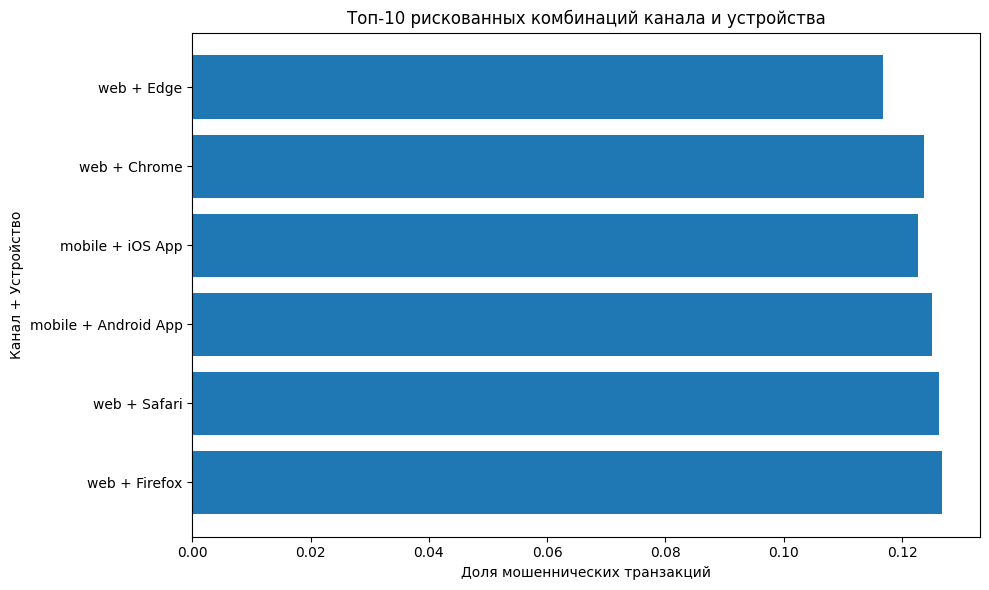

In [11]:
channel_device_df = (
    df[df.channel != "pos"].groupby(["channel", "device"])
    .agg(
        total_transactions=("is_fraud", "size"),
        fraud_transactions=("is_fraud", "sum"),
        fraud_rate=("is_fraud", "mean")
    )
    .sort_values("fraud_transactions", ascending=False)
    .reset_index()
)


print(channel_device_df.head(10))


top_10 = channel_device_df.head(10)
plt.figure(figsize=(10, 6))
plt.barh(
    width=top_10["fraud_rate"],
    y=top_10["channel"] + " + " + top_10["device"]
)
plt.title("Топ-10 рискованных комбинаций канала и устройства")
plt.xlabel("Доля мошеннических транзакций")
plt.ylabel("Канал + Устройство")
plt.tight_layout()
plt.show()

## Гипотеза 2: всплеск акктивности
1) если подтвердится, позволит быстрее обнураживать такую активность в рилтайме
2) если пошло слишком много последовательных операций, и у слишком многих вендоров – кто-то хочет поскорее потратить побольше денег, пока его не отследили

Вывод: при грубом анализе не подтвердилась


In [49]:
if not "last_hour_num_transactions" in df.columns:
    activity_features = pd.json_normalize(df["last_hour_activity"]).add_prefix("last_hour_")
    df = pd.concat([df, activity_features], axis=1)

activity_metrics = [
    "last_hour_num_transactions",
    "last_hour_total_amount", 
    "last_hour_unique_merchants",
    "last_hour_unique_countries",
    "last_hour_max_single_amount"
]


fraud_activity = df[df["is_fraud"]][activity_metrics].mean()
legit_activity = df[~df["is_fraud"]][activity_metrics].mean()

activity_comparison = pd.DataFrame({
    "fraud_mean": fraud_activity,
    "legit_mean": legit_activity,
    "ratio": fraud_activity / legit_activity
})
activity_comparison

,fraud_mean,legit_mean,ratio
last_hour_num_transactions,412.67,408.26,1.01
last_hour_total_amount,20154995.52,19857837.34,1.01
last_hour_unique_merchants,80.45,79.92,1.01
last_hour_unique_countries,10.71,10.65,1.01
last_hour_max_single_amount,1752255.49,1719986.75,1.02


In [35]:
user_normal_activity = (
    df[~df["is_fraud"]]
    .groupby("customer_id")
    .agg(
        avg_amount=("amount", "mean"),
        median_amount=("amount", "median"),
        daily_tx_count=("transaction_id", "count")
    )
    .reset_index()
)
df_ = df.merge(user_normal_activity, on="customer_id", how="left")
df_["last_hour_avg_amount"] = (df_["last_hour_total_amount"] / df_["last_hour_num_transactions"]).replace([np.inf, -np.inf], 0)

comparison = df_[df_["is_fraud"]][[
    "customer_id",
    "avg_amount",
    "median_amount",
    "daily_tx_count",
    "last_hour_num_transactions",
    "last_hour_total_amount",
    "last_hour_unique_merchants",
    "last_hour_avg_amount",
    "last_hour_max_single_amount"

]].copy()

comparison["avg_amount_ratio"] = comparison["last_hour_avg_amount"] / comparison["avg_amount"]
comparison["max_amount_ratio"] = comparison["last_hour_max_single_amount"] / comparison["avg_amount"]
comparison["tx_count_ratio"] = comparison["last_hour_num_transactions"] / comparison["daily_tx_count"]


print("Средние отношения показателей за час к обычной активности:")
print(comparison[["avg_amount_ratio", "max_amount_ratio"]].mean())

print("\nТоп-5 самых аномальных операций по количеству транзакций:")
comparison.sort_values("tx_count_ratio", ascending=False).head(5)

Средние отношения показателей за час к обычной активности:
avg_amount_ratio     5.32
max_amount_ratio   291.58
dtype: float64

Топ-5 самых аномальных операций по количеству транзакций:


,customer_id,avg_amount,median_amount,daily_tx_count,last_hour_num_transactions,last_hour_total_amount,last_hour_unique_merchants,last_hour_avg_amount,last_hour_max_single_amount,avg_amount_ratio,max_amount_ratio,tx_count_ratio
6363,CUST_52904,1886.49,342.73,1269,1585,36981355.52,105,23332.09,1909973.25,12.37,1012.45,1.25
5420,CUST_52012,3336.78,205.40,1004,1254,28604781.38,105,22810.83,1340536.26,6.84,401.75,1.25
9826,CUST_60039,4713.68,391.34,1488,1858,58399368.46,105,31431.31,3119503.86,6.67,661.80,1.25
20258,CUST_89947,36385.55,29848.62,913,1140,67524227.29,105,59231.78,4045334.85,1.63,111.18,1.25
890,CUST_26373,12209.27,1539.30,1263,1577,56612416.61,105,35898.81,2004534.20,2.94,164.18,1.25


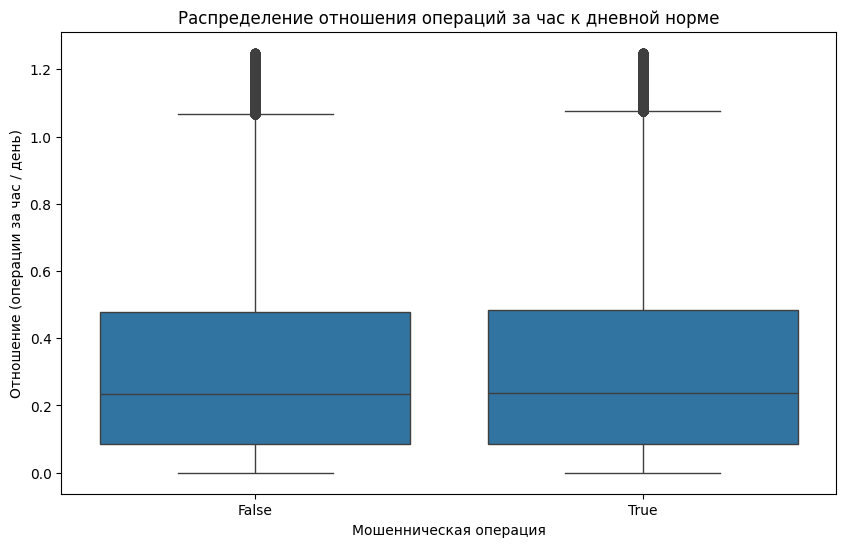

In [ ]:
df_["tx_count_ratio"] = df_["last_hour_num_transactions"] / df_["daily_tx_count"]

plt.figure(figsize=(10, 6))
sns.boxplot(x="is_fraud", y="tx_count_ratio", data=df_) # выбросы
plt.title("Распределение отношения операций за час к дневной норме")
plt.xlabel("Мошенническая операция")
plt.ylabel("Отношение (операции за последний час / день)")
plt.show()

## Гипотеза 3: день недели и время суток

Идея в том, что поведение людей в разное время различается – на выходных, например, они могут становиться менее бдительны

Вывод: подтвердилась, но не про выходные, а про ночное время. C 1 ночи до 5 утра отношение мошеннических операций ко всем максимальное.

/var/folders/3w/r7v1f_z53p50ccf_m5x4mdgm0000gn/T/ipykernel_18992/1978364125.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["day_of_week", "time_of_day"])["is_fraud"]


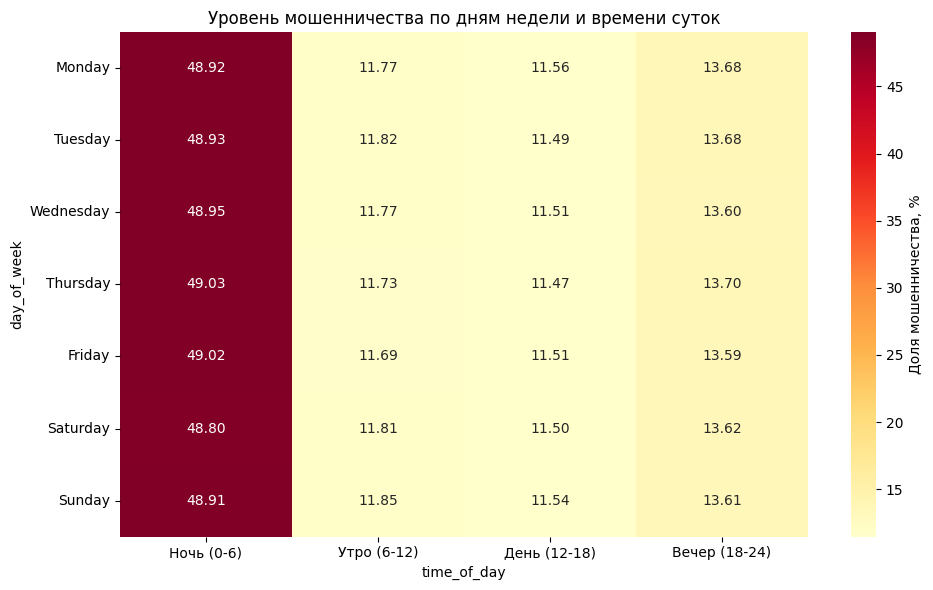

In [51]:
df["day_of_week"] = df["timestamp"].dt.day_name()
df["time_of_day"] = pd.cut(
    df["timestamp"].dt.hour,
    bins=[0, 6, 12, 18, 24],
    labels=["Ночь (0-6)", "Утро (6-12)", "День (12-18)", "Вечер (18-24)"]
)


fraud_rate = (
    df.groupby(["day_of_week", "time_of_day"])["is_fraud"]
    .mean()
    .unstack()
    .reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
)

plt.figure(figsize=(10, 6))
sns.heatmap(
    fraud_rate * 100, annot=True, fmt=".2f", cmap="YlOrRd", 
    cbar_kws={"label": "Доля мошенничества, %"}
)
plt.title("Уровень мошенничества по дням недели и времени суток")
plt.tight_layout()
plt.show()

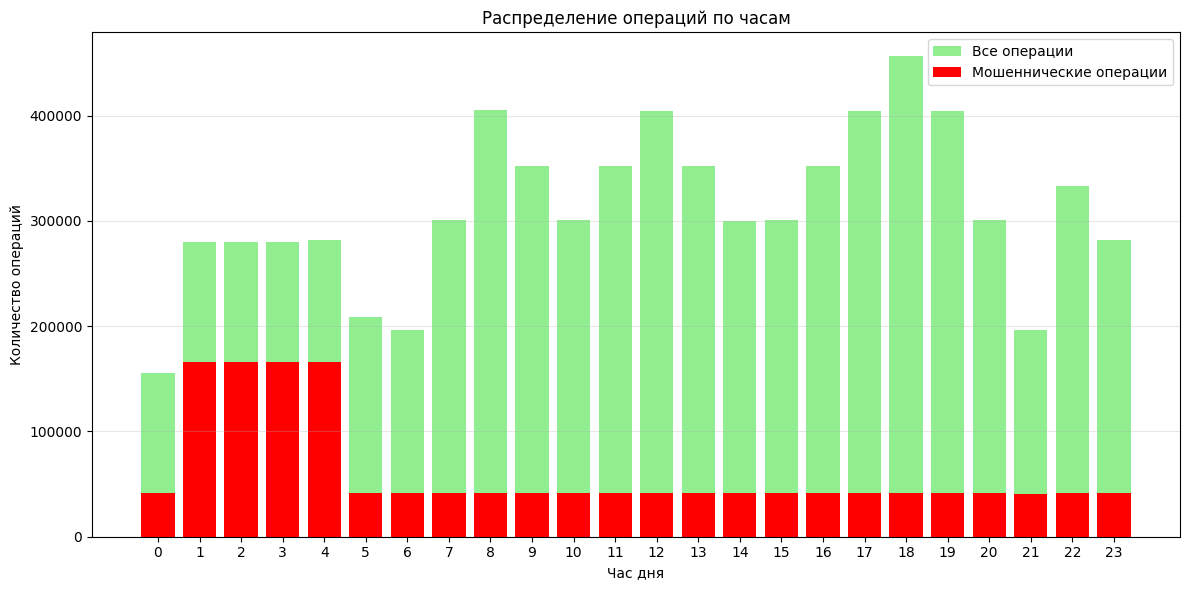

In [55]:
df["hour"] = df["timestamp"].dt.hour
by_hour = df.groupby("hour")["is_fraud"].agg(
    total_tx="size",
    fraud_tx="sum"
).reset_index()

plt.figure(figsize=(12, 6))
plt.bar(by_hour["hour"], by_hour["total_tx"], 
        color="lightgreen", label="Все операции")
plt.bar(by_hour["hour"], by_hour["fraud_tx"], 
        color="red", label="Мошеннические операции")
plt.xlabel("Час дня")
plt.ylabel("Количество операций")
plt.title("Распределение операций по часам")
plt.xticks(range(24))
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# Задания 50-60

In [6]:
df.columns

Index(['transaction_id', 'customer_id', 'card_number', 'timestamp',
       'vendor_category', 'vendor_type', 'vendor', 'amount', 'currency',
       'country', 'city', 'city_size', 'card_type', 'is_card_present',
       'device', 'channel', 'device_fingerprint', 'ip_address',
       'is_outside_home_country', 'is_high_risk_vendor', 'is_weekend',
       'last_hour_activity', 'is_fraud'],
      dtype='object')

In [7]:
df.head(1)

,transaction_id,customer_id,card_number,timestamp,vendor_category,vendor_type,vendor,amount,currency,country,city,city_size,card_type,is_card_present,device,channel,device_fingerprint,ip_address,is_outside_home_country,is_high_risk_vendor,is_weekend,last_hour_activity,is_fraud
0,TX_a0ad2a2a,CUST_72886,6646734767813109,2024-09-30 00:00:01.034820,Restaurant,fast_food,Taco Bell,294.87,GBP,UK,Unknown City,medium,Platinum Credit,False,iOS App,mobile,e8e6160445c935fd0001501e4cbac8bc,197.153.60.199,False,False,False,"{'num_transactions': 1197, 'total_amount': 33498556.080464985, 'unique_merchants': 105, 'unique_...",False


In [68]:
# 50
df_fraud = df[df.is_fraud]
df_fraud.shape[0] / df.shape[0]

0.19972818498066347

In [13]:
# 51
",".join(df_fraud.country.value_counts()[:5].index)

'Russia,Mexico,Brazil,Nigeria,Australia'

In [14]:
df.timestamp.dtype

dtype('<M8[us]')

In [18]:
# 52

df["hour"] = df["timestamp"].dt.floor("H")
transactions_per_hour = df.groupby(["customer_id", "hour"]).size().reset_index(name="transaction_id")
avg_per_customer = transactions_per_hour.groupby("customer_id")["transaction_id"].mean()

avg_per_customer.mean()

/var/folders/3w/r7v1f_z53p50ccf_m5x4mdgm0000gn/T/ipykernel_12851/795944520.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df["hour"] = df["timestamp"].dt.floor("H")


np.float64(2.4264024824921666)

In [19]:
# 53
hr_df = df[df.is_high_risk_vendor]
hr_df.is_fraud.sum() / hr_df.shape[0]

np.float64(0.19998632451602943)

In [24]:
# 54
df.groupby("city").agg({"amount": "mean"}).sort_values(by="amount", ascending=False)

,amount
city,
Unknown City,51315.780071
New York,568.872467
San Antonio,567.921894
San Jose,567.263760
Phoenix,565.730142
San Diego,565.593140
Chicago,565.277374
Houston,564.961388
Los Angeles,563.900769


In [ ]:
# 55
df[df.vendor_type=="fast_food"].groupby("city").agg({"amount": "mean"}).sort_values(by="amount", ascending=False)

,amount
city,
Unknown City,15214.407916
Chicago,264.450281
New York,263.296441
San Antonio,258.169691
Los Angeles,255.950324
San Diego,254.343884
Dallas,248.685716
San Jose,247.892502
Houston,246.913137


In [ ]:
cur_exc = pd.read_parquet("historical_currency_exchange.parquet")
cur_exc = cur_exc.melt(id_vars="date", var_name="currency")
cur_exc

In [ ]:
df["date"] = df.timestamp.dt.date
df_ = df.merge(
    cur_exc,
    how="left",
    on=["date", "currency"],
)
df_["in_usd"] = df_.amount / df_.value
df_.sample(2)

,transaction_id,customer_id,card_number,timestamp,vendor_category,vendor_type,vendor,amount,currency,country,city,city_size,card_type,is_card_present,device,channel,device_fingerprint,ip_address,is_outside_home_country,is_high_risk_vendor,is_weekend,last_hour_activity,is_fraud,hour,date,value,in_usd
2577072,TX_7e649a2d,CUST_49001,4882661418880724,2024-10-10 16:49:02.874783,Education,online,MasterClass,323.95,GBP,UK,Unknown City,medium,Premium Debit,False,Chrome,web,406ccc9e3bbe8903cb488e455d079a17,73.143.235.201,False,False,False,"{'num_transactions': 1015, 'total_amount': 52988365.17738855, 'unique_merchants': 105, 'unique_c...",False,2024-10-10 16:00:00,2024-10-10,0.764894,423.522648
3791094,TX_71bbfe0f,CUST_67872,6530338597581032,2024-10-15 17:18:56.647874,Healthcare,medical,Local Hospital,132889.53,RUB,Russia,Unknown City,medium,Basic Credit,False,Chrome,web,a24f00659de0f1352a83505145d54732,143.67.186.161,True,False,False,"{'num_transactions': 710, 'total_amount': 17498950.00152343, 'unique_merchants': 105, 'unique_co...",True,2024-10-15 17:00:00,2024-10-15,95.165613,1396.402813


In [50]:
# 56
df_[~df_.is_fraud].in_usd.mean()

np.float64(459.7826108501773)

In [51]:
# 57
df_[~df_.is_fraud].in_usd.std()

np.float64(417.0077334756039)

In [52]:
# 58
df_[df_.is_fraud].in_usd.mean()

np.float64(874.6067503080814)

In [53]:
# 59
df_[df_.is_fraud].in_usd.std()

np.float64(1349.882692206744)

In [55]:
# 60

hourly_unique_merchants = (
    df.groupby(["customer_id", pd.Grouper(key="timestamp", freq="H")])
    ['vendor'].nunique()
    .reset_index(name="unique_merchants")
)

median_per_customer = (
    hourly_unique_merchants.groupby("customer_id")["unique_merchants"]
    .median()
    .reset_index(name="median_unique_merchants")
)

threshold = median_per_customer["median_unique_merchants"].quantile(0.95)
dangerous_customers = median_per_customer[median_per_customer["median_unique_merchants"] > threshold]

len(dangerous_customers)

/var/folders/3w/r7v1f_z53p50ccf_m5x4mdgm0000gn/T/ipykernel_12851/3178351935.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.groupby(["customer_id", pd.Grouper(key="timestamp", freq="H")])


100